In [1]:
%config Completer.use_jedi = False

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import math
import seaborn as sns

In [135]:
from sklearn.metrics import r2_score,mean_squared_error

In [128]:
from sklearn.tree import DecisionTreeRegressor

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [25]:
df = pd.read_csv('./datalab/ford.csv')

In [107]:
df.head()

,model,year,price,transmission,km_driven,fuelType,tax,mpg,engineSize,age,avg_km
0,Fiesta,2017,12000,Automatic,15944.000000,Petrol,150.0,57.7,1.0,4,3986.000000
1,Focus,2018,14000,Manual,9083.000000,Petrol,150.0,57.7,1.0,3,3027.666667
2,Focus,2017,13000,Manual,12456.000000,Petrol,150.0,57.7,1.0,4,3114.000000
3,Fiesta,2019,17500,Manual,10460.000000,Petrol,145.0,40.3,1.5,2,5230.000000
4,Fiesta,2019,16500,Automatic,23363.630504,Petrol,145.0,48.7,1.0,2,11681.815252


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17965 entries, 0 to 17964
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         17965 non-null  object 
 1   year          17965 non-null  int64  
 2   price         17965 non-null  int64  
 3   transmission  17965 non-null  object 
 4   km_driven     17965 non-null  float64
 5   fuelType      17965 non-null  object 
 6   tax           17965 non-null  float64
 7   mpg           17965 non-null  float64
 8   engineSize    17965 non-null  float64
 9   age           17965 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 1.4+ MB


In [106]:
df.describe()

,year,price,km_driven,tax,mpg,engineSize,age,avg_km
count,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000
mean,2016.864180,12279.756415,24478.605618,122.776734,57.906991,1.350827,4.135820,5953.739516
std,2.024931,4741.382606,18787.152412,40.523140,10.125977,0.432371,2.024931,3669.396411
min,1996.000000,495.000000,2500.000000,20.000000,20.800000,0.000000,1.000000,500.000000
25%,2016.000000,8999.000000,11500.000000,113.334539,52.300000,1.000000,3.000000,3489.000000
50%,2017.000000,11291.000000,20391.000000,145.000000,58.900000,1.200000,4.000000,5176.000000
75%,2018.000000,15299.000000,31064.000000,145.000000,65.700000,1.500000,5.000000,7449.800000
max,2020.000000,54995.000000,177644.000000,150.000000,201.800000,5.000000,25.000000,29975.500000


In [56]:
df.rename(columns={'mileage':'km_driven'}, inplace=True)

In [87]:
df['age'] = 2021 - df.year

In [105]:
df['avg_km'] = df.km_driven/df.age

## Feature Engineering

In [29]:
df.year = df.year.apply(lambda x: 2017 if x==2060 else x) 

<AxesSubplot:xlabel='age', ylabel='price'>

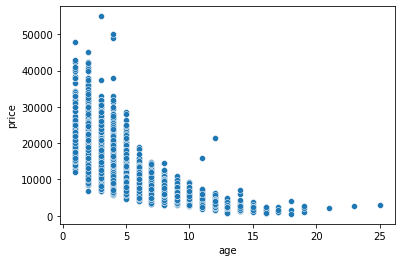

In [91]:
sns.scatterplot(x = df.age, y= df.price)

<AxesSubplot:xlabel='price', ylabel='km_driven'>

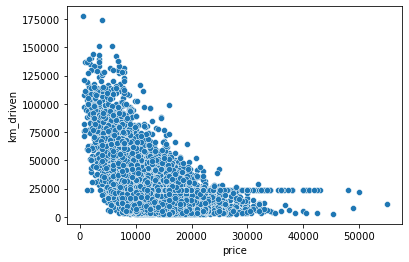

In [103]:
sns.scatterplot(x = df.price, y= df.km_driven)

In [86]:
mean_km = df.km_driven.mean()
quantile_Km = df.km_driven.quantile(.99)
print("KM Mean {}, Q {}".format(mean_km, quantile_Km))

KM Mean 24478.605618222406, Q 94000.0


In [82]:
df.km_driven = df.km_driven.apply(lambda x: mean_km if x < quantile_Km else x)

In [47]:
mean_tax = df.tax.mean()
print('Mean Tax {}, Q1 {}, Q3 {}'.format(mean_tax, df.tax.quantile(.1),df.tax.quantile(.9)))

Mean Tax 122.77673438851173, Q1 30.0, Q3 150.0


In [46]:
df.tax = df.tax.apply(lambda x: 126.91 if x > 150 else x)

In [34]:
df.tax = df.tax.apply(lambda x : mean_tax if  x == 0 else x)

In [56]:
def toRemoveValues(df, column, counts):
    value_counts = df[column].value_counts()
    to_remove = value_counts[value_counts <= counts].index
    df = df[~df[column].isin(to_remove)]
    return df

In [78]:
def getValueCounts(df, column):
    print(f'#### Value Counts for %s ####'%column)
    print(df[column].value_counts())

In [57]:
df = toRemoveValues(df, 'model', 50)

In [58]:
df.model.value_counts()

 Fiesta                   6557
 Focus                    4588
 Kuga                     2225
 EcoSport                 1143
 C-MAX                     543
 Ka+                       531
 Mondeo                    526
 B-MAX                     355
 S-MAX                     296
 Grand C-MAX               247
 Galaxy                    228
 Edge                      208
 KA                        199
 Puma                       80
 Tourneo Custom             69
 Grand Tourneo Connect      59
 Mustang                    57
Name: model, dtype: int64

In [63]:
df = toRemoveValues(df, 'year', 50)
df.year.value_counts()

2017    4881
2018    4013
2019    3187
2016    2318
2015    1363
2014     804
2013     608
2020     257
2012     115
2011      93
2009      88
2010      63
2008      54
Name: year, dtype: int64

In [72]:
getValueCounts(df, 'transmission')

#### Value Counts for transmission ####

Manual       15416
Automatic     1341
Semi-Auto     1087
Name: transmission, dtype: int64


In [76]:
getValueCounts(df, 'fuelType')

#### Value Counts for fuelType ####

Petrol    12109
Diesel     5710
Hybrid       22
Name: fuelType, dtype: int64


In [75]:
df = toRemoveValues(df, 'fuelType', 3)

In [84]:
print('Median: {}, Mode: {}, mean: {}'.format(df.tax.median(), df.tax.mode(), df.tax.mean() ))

Median: 145.0, Mode: 0    145
dtype: int64, mean: 112.91043102965081


In [89]:
mean = df.tax.mean()
df.tax = df.tax.apply(lambda x : mean if x == 0 else x)

In [92]:
df = toRemoveValues(df, 'tax', 5)

In [108]:
df.corr()

,year,price,km_driven,tax,mpg,engineSize,age,avg_km
year,1.000000,0.645419,-0.680485,0.431848,-0.021494,-0.139217,-1.000000,0.019514
price,0.645419,1.000000,-0.477797,0.385198,-0.346427,0.411156,-0.645419,0.001390
km_driven,-0.680485,-0.477797,1.000000,-0.333254,0.092248,0.218540,0.680485,0.608674
tax,0.431848,0.385198,-0.333254,1.000000,-0.210192,0.022330,-0.431848,-0.042708
mpg,-0.021494,-0.346427,0.092248,-0.210192,1.000000,-0.260527,0.021494,0.077467
engineSize,-0.139217,0.411156,0.218540,0.022330,-0.260527,1.000000,0.139217,0.136975
age,-1.000000,-0.645419,0.680485,-0.431848,0.021494,0.139217,1.000000,-0.019514
avg_km,0.019514,0.001390,0.608674,-0.042708,0.077467,0.136975,-0.019514,1.000000


In [109]:
df.head(2)

,model,year,price,transmission,km_driven,fuelType,tax,mpg,engineSize,age,avg_km
0,Fiesta,2017,12000,Automatic,15944.0,Petrol,150.0,57.7,1.0,4,3986.000000
1,Focus,2018,14000,Manual,9083.0,Petrol,150.0,57.7,1.0,3,3027.666667


In [110]:
df.transmission.value_counts()

Manual       15517
Automatic     1361
Semi-Auto     1087
Name: transmission, dtype: int64

In [168]:
df.to_csv('./datalab/ford_train.csv', index=False)

In [111]:
df_train = pd.get_dummies(df, columns=['model', 'transmission', 'fuelType'], drop_first=True)

In [112]:
df_train.head()

,year,price,km_driven,tax,mpg,engineSize,age,avg_km,model_ C-MAX,model_ EcoSport,...,model_ Streetka,model_ Tourneo Connect,model_ Tourneo Custom,model_ Transit Tourneo,transmission_Manual,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2017,12000,15944.000000,150.0,57.7,1.0,4,3986.000000,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2018,14000,9083.000000,150.0,57.7,1.0,3,3027.666667,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2017,13000,12456.000000,150.0,57.7,1.0,4,3114.000000,0,0,...,0,0,0,0,1,0,0,0,0,1
3,2019,17500,10460.000000,145.0,40.3,1.5,2,5230.000000,0,0,...,0,0,0,0,1,0,0,0,0,1
4,2019,16500,23363.630504,145.0,48.7,1.0,2,11681.815252,0,0,...,0,0,0,0,0,0,0,0,0,1


In [113]:
df_train.columns

Index(['year', 'price', 'km_driven', 'tax', 'mpg', 'engineSize', 'age',
       'avg_km', 'model_ C-MAX', 'model_ EcoSport', 'model_ Edge',
       'model_ Escort', 'model_ Fiesta', 'model_ Focus', 'model_ Fusion',
       'model_ Galaxy', 'model_ Grand C-MAX', 'model_ Grand Tourneo Connect',
       'model_ KA', 'model_ Ka+', 'model_ Kuga', 'model_ Mondeo',
       'model_ Mustang', 'model_ Puma', 'model_ Ranger', 'model_ S-MAX',
       'model_ Streetka', 'model_ Tourneo Connect', 'model_ Tourneo Custom',
       'model_ Transit Tourneo', 'transmission_Manual',
       'transmission_Semi-Auto', 'fuelType_Electric', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol'],
      dtype='object')

In [139]:
X = df_train.drop(columns=['price','year'], axis=0)

In [140]:
X = X.values

In [141]:
X.shape

(17965, 34)

In [142]:
Y = df_train['price'].values

### Splitting the dataset into the Training set and Test set

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.22, random_state = 0)

### Training the Multiple Linear Regression model on the Training set

In [144]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

## Predicting the Test set results

In [145]:
y_pred = regressor.predict(X_test)

In [146]:
regressor.score(X_test, y_test)

0.844685266092628

In [147]:
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[:20])

[[12498.43 11670.  ]
 [10698.68 10000.  ]
 [13506.08 11599.  ]
 [13851.85 14899.  ]
 [16236.2  19498.  ]
 [12882.2  10790.  ]
 [ 7520.46  6800.  ]
 [18846.33 25500.  ]
 [ 8735.62  8000.  ]
 [20674.37 18995.  ]
 [ 9924.16  9690.  ]
 [16403.4  16570.  ]
 [14224.21 13400.  ]
 [13923.52 13490.  ]
 [ 5996.24  1299.  ]
 [11412.32 10799.  ]
 [13499.17 12698.  ]
 [ 6448.51  8000.  ]
 [14184.13 12490.  ]
 [14307.22 13250.  ]]


In [148]:
print('Variance score: %.2f' % regressor.score(X_test, y_test))

Variance score: 0.84


In [149]:
print('VarScore:{:.3f}'.format(metrics.explained_variance_score(y_test,y_pred)))

<IPython.core.display.Javascript object>

VarScore:0.845


In [150]:
r2_score(y_test, y_pred)

0.844685266092628

In [151]:
from sklearn.ensemble import RandomForestRegressor

In [165]:
regressor = RandomForestRegressor(n_estimators=450, max_depth=12)
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=450)

In [166]:
regressor.score(X_test, y_test)

0.9348363618578428

In [167]:
print('VarScore:{:.3f}'.format(metrics.explained_variance_score(y_test,y_pred)))

<IPython.core.display.Javascript object>

VarScore:0.845
